In [1]:
import sys
import os
from typing import Tuple
from dotenv import load_dotenv

root_dir = os.path.abspath("..")
sys.path.append(root_dir)
dotenv_path = os.path.join(root_dir, ".env")
load_dotenv(dotenv_path)

True

In [2]:
import polars as pl
import matplotlib.pyplot as plt

In [3]:
train_file = os.path.join(root_dir, "kaggle", "train.parquet")

train = pl.read_parquet(train_file, low_memory=True)

In [4]:
train.head(10)

Id,bySelf,companyID,corporateTariffCode,frequentFlyer,nationality,isAccess3D,isVip,legs0_arrivalAt,legs0_departureAt,legs0_duration,legs0_segments0_aircraft_code,legs0_segments0_arrivalTo_airport_city_iata,legs0_segments0_arrivalTo_airport_iata,legs0_segments0_baggageAllowance_quantity,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_cabinClass,legs0_segments0_departureFrom_airport_iata,legs0_segments0_duration,legs0_segments0_flightNumber,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments0_seatsAvailable,legs0_segments1_aircraft_code,legs0_segments1_arrivalTo_airport_city_iata,legs0_segments1_arrivalTo_airport_iata,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_cabinClass,legs0_segments1_departureFrom_airport_iata,legs0_segments1_duration,legs0_segments1_flightNumber,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments1_seatsAvailable,legs0_segments2_aircraft_code,legs0_segments2_arrivalTo_airport_city_iata,…,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_cabinClass,legs1_segments2_departureFrom_airport_iata,legs1_segments2_duration,legs1_segments2_flightNumber,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments2_seatsAvailable,legs1_segments3_aircraft_code,legs1_segments3_arrivalTo_airport_city_iata,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_cabinClass,legs1_segments3_departureFrom_airport_iata,legs1_segments3_duration,legs1_segments3_flightNumber,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs1_segments3_seatsAvailable,miniRules0_monetaryAmount,miniRules0_percentage,miniRules0_statusInfos,miniRules1_monetaryAmount,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_isAccessTP,pricingInfo_passengerCount,profileId,ranker_id,requestDate,searchRoute,sex,taxes,totalPrice,selected,__index_level_0__
i64,bool,i64,i64,str,i64,bool,bool,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,str,str,…,f64,f64,str,str,str,str,str,f64,str,str,str,f64,f64,f64,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,str,datetime[ns],str,bool,f64,f64,i64,i64
0,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T16:20:00""","""2024-06-15T15:40:00""","""02:40:00""","""YK2""","""KJA""","""KJA""",1.0,0.0,1.0,"""TLK""","""02:40:00""","""216""","""KV""","""KV""",9.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,370.0,16884.0,1,0
1,true,57323,123,"""S7/SU/UT""",36,true,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf6964640b63079fbafd42c…",2024-05-17 03:03:08,"""TLKKJA/KJATLK""",true,2240.0,51125.0,0,1
2,true,57323,null,"""S7/SU/UT""",36,false,false,"""2024-06-15T14:50:00""","""2024-06-15T09:25:00""","""07:25:00""","""E70""","""OVB""","""OVB""",1.0,0.0,1.0,"""TLK""","""02:50:00""","""5358""","""S7""","""S7""",4.0,"""E70""","""KJA""","""KJA""",1.0,0.0,1.0,"""OVB""","""01:20:00""","""5311""","""S7""","""S7""",4.0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2300.0,null,1.0,3500.0,null,1.0,1.0,1,2087645,"""98ce0dabf696

# EDA

In [4]:
# Basic train size
print(train.shape)
print(train.columns[:30])
print(train.head(5))

(18145372, 127)
['Id', 'bySelf', 'companyID', 'corporateTariffCode', 'frequentFlyer', 'nationality', 'isAccess3D', 'isVip', 'legs0_arrivalAt', 'legs0_departureAt', 'legs0_duration', 'legs0_segments0_aircraft_code', 'legs0_segments0_arrivalTo_airport_city_iata', 'legs0_segments0_arrivalTo_airport_iata', 'legs0_segments0_baggageAllowance_quantity', 'legs0_segments0_baggageAllowance_weightMeasurementType', 'legs0_segments0_cabinClass', 'legs0_segments0_departureFrom_airport_iata', 'legs0_segments0_duration', 'legs0_segments0_flightNumber', 'legs0_segments0_marketingCarrier_code', 'legs0_segments0_operatingCarrier_code', 'legs0_segments0_seatsAvailable', 'legs0_segments1_aircraft_code', 'legs0_segments1_arrivalTo_airport_city_iata', 'legs0_segments1_arrivalTo_airport_iata', 'legs0_segments1_baggageAllowance_quantity', 'legs0_segments1_baggageAllowance_weightMeasurementType', 'legs0_segments1_cabinClass', 'legs0_segments1_departureFrom_airport_iata']
shape: (5, 127)
┌─────┬────────┬────────

In [5]:
# Selected mean
print(train.select(pl.col("selected")).mean())

shape: (1, 1)
┌──────────┐
│ selected │
│ ---      │
│ f64      │
╞══════════╡
│ 0.005816 │
└──────────┘


In [6]:
# Group sizes (important for ranking)
group_sizes = train.group_by("ranker_id").len()
print(group_sizes.describe())

shape: (9, 3)
┌────────────┬─────────────────────────────────┬────────────┐
│ statistic  ┆ ranker_id                       ┆ len        │
│ ---        ┆ ---                             ┆ ---        │
│ str        ┆ str                             ┆ f64        │
╞════════════╪═════════════════════════════════╪════════════╡
│ count      ┆ 105539                          ┆ 105539.0   │
│ null_count ┆ 0                               ┆ 0.0        │
│ mean       ┆ null                            ┆ 171.93049  │
│ std        ┆ null                            ┆ 445.940118 │
│ min        ┆ 00004b95a9e446b586c5e9b7297144… ┆ 1.0        │
│ 25%        ┆ null                            ┆ 19.0       │
│ 50%        ┆ null                            ┆ 50.0       │
│ 75%        ┆ null                            ┆ 154.0      │
│ max        ┆ ffffb2f91f8c43cba68e87edf3782e… ┆ 8236.0     │
└────────────┴─────────────────────────────────┴────────────┘


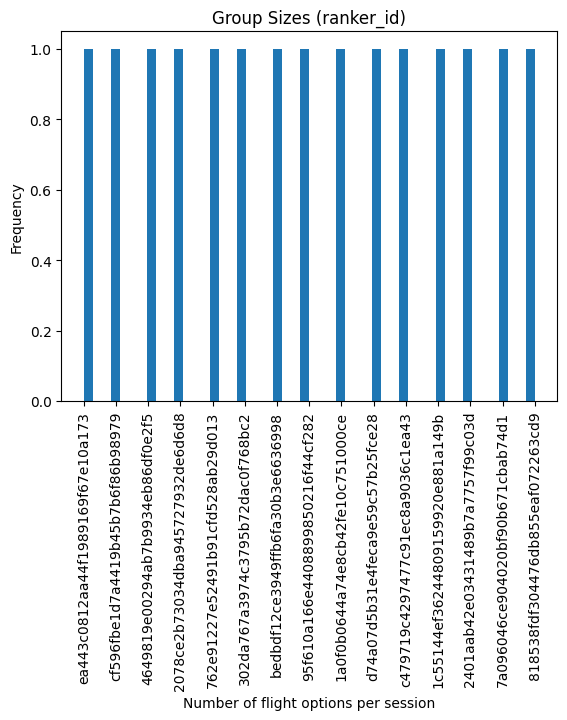

In [7]:
# Optionally histogram
sizes = group_sizes.head(15).to_series().to_list()

plt.hist(sizes, bins=50)
plt.xlabel("Number of flight options per session")
plt.ylabel("Frequency")
plt.title("Group Sizes (ranker_id)")
plt.xticks(rotation=90)
plt.show()

In [8]:
train.select([
    pl.col("totalPrice"),
    pl.col("taxes"),
    pl.col("legs0_duration"),
]).describe()

statistic,totalPrice,taxes,legs0_duration
str,f64,f64,str
"""count""",1.8145372e7,1.8145372e7,"""18145372"""
"""null_count""",0.0,0.0,"""0"""
"""mean""",46314.437648,4284.696386,null
"""std""",75068.076159,11839.754918,null
"""min""",770.0,0.0,"""00:30:00"""
"""25%""",12897.0,1006.0,null
"""50%""",24976.0,1246.0,null
"""75%""",55108.0,1746.0,null
"""max""",9.944355e6,897921.0,"""6.03:15:00"""
